In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import preprocessing
from itertools import product
from scipy import interpolate, stats
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [57]:
# Load data as a dataframe
data = pd.read_csv(r"C:\Users\Edwin\Downloads\test_df")
data = data.drop(data.index[0]) # drop dumb header
# data = data[data['400.0nm'] < 0.2] # remove sample outlier, but in reality should not be needed to remove
data

,UID,Component 1 wtf,Component 2 wtf,Component 3 wtf,Component 4 wtf,Component 5 wtf,Slot,Labware,Well,400.0nm,450.0nm,500.0nm,550.0nm,600.0nm,650.0nm
1,2020-11-23_ethanol_PFH_A1,0.0003,0.000125,0.0002512820512820513,0.41704545454545455,0.5822782634032634,2,Corning 96 Well Plate 360 µL Flat,A1,0.078,0.066,0.057,0.053,0.050,0.047
2,2020-11-23_ethanol_PFH_A2,0.0003,0.000125,0.0002512820512820513,0.43863636363636366,0.5606873543123543,2,Corning 96 Well Plate 360 µL Flat,A2,0.719,0.709,0.700,0.695,0.694,0.693
3,2020-11-23_ethanol_PFH_A3,0.0003,0.000125,0.0002512820512820513,0.4602272727272727,0.5390964452214453,2,Corning 96 Well Plate 360 µL Flat,A3,0.481,0.464,0.452,0.443,0.437,0.432
4,2020-11-23_ethanol_PFH_A4,0.0003,0.000125,0.0002512820512820513,0.4818181818181818,0.5175055361305361,2,Corning 96 Well Plate 360 µL Flat,A4,0.673,0.654,0.644,0.636,0.632,0.624
5,2020-11-23_ethanol_PFH_A5,0.0003,0.000125,0.0002512820512820513,0.5034090909090909,0.4959146270396271,2,Corning 96 Well Plate 360 µL Flat,A5,0.082,0.070,0.061,0.057,0.053,0.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,2020-11-23_ethanol_PFH_A8,0.0003,0.000125,0.0020666666666666667,0.9136363636363637,0.08387196969696964,6,Corning 96 Well Plate 360 µL Flat,A8,0.042,0.039,0.039,0.039,0.040,0.039
201,2020-11-23_ethanol_PFH_A9,0.0003,0.000125,0.0020666666666666667,0.9352272727272728,0.062281060606060534,6,Corning 96 Well Plate 360 µL Flat,A9,0.043,0.041,0.041,0.041,0.040,0.039
202,2020-11-23_ethanol_PFH_A10,0.0003,0.000125,0.0020666666666666667,0.9568181818181819,0.04069015151515143,6,Corning 96 Well Plate 360 µL Flat,A10,0.043,0.041,0.039,0.039,0.040,0.039
203,2020-11-23_ethanol_PFH_A11,0.0003,0.000125,0.002217948717948718,0.9568181818181819,0.04053886946386942,6,Corning 96 Well Plate 360 µL Flat,A11,0.042,0.041,0.041,0.041,0.041,0.040


In [41]:
# load/isolate variable inputs and outputs
pfh = np.asarray(pd.to_numeric(data['Component 3 wtf'] , errors='coerce')[:-1])
ethanol = np.asarray(pd.to_numeric(data['Component 4 wtf'] , errors='coerce')[:-1])
absorbance = np.asarray(pd.to_numeric(data['400.0nm'] , errors='coerce')[:-1])

In [58]:
# load and standardize data
x1_training = ethanol
x2_training = pfh 
y_training = absorbance

x1_training_f = x1_training[:, np.newaxis]
scalerx1 = preprocessing.RobustScaler().fit(x1_training_f) #not a huge diff between robustscalar and standardscalar
x1_training_scaled = scalerx1.transform(x1_training_f)

x2_training_f = x2_training[:, np.newaxis]
scalerx2 = preprocessing.RobustScaler().fit(x2_training_f)
x2_training_scaled = scalerx2.transform(x2_training_f)

x1x2_training_scaled = np.asarray([x1_training_scaled[:,0], x2_training_scaled[:,0]]).T

y_training_f = y_training[:, np.newaxis]
scalery = preprocessing.RobustScaler().fit(y_training_f)
y_training_scaled = scalery.transform(y_training_f)
# [:,0]

In [59]:
# x1x2_training_scaled # the higher dimension requirment all stemmed from this : /

In [60]:
# Create the model and fit the data 
kernal = C(1, (1e-1, 1e3)) * RBF(1, (1e-3, 1e3)) 
gpmodel = GaussianProcessRegressor(kernel=kernal, n_restarts_optimizer=10,alpha=0.05, normalize_y=True) # random_state=42
gpmodel.fit(x1x2_training_scaled, y_training_scaled)

GaussianProcessRegressor(alpha=0.05, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True)

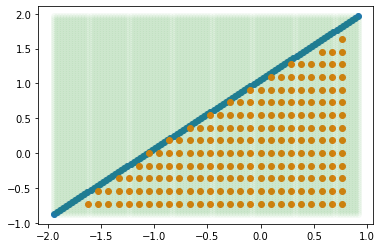

In [61]:
# Create test data and mesh

# I dont think you need to scale the linspace just make it to min and max of the scaled data
# Do the product mesh operation, then after you predict you can convert using the inverse since its in the min and max linspace of scaled
# odd since you never applied it to the thing to being with by lets see


# All data is in (1,n) format for easier working with sklearn, need to convert if need list or value 
# you can make it so you start with bare exposed 
# NOTE making the input of min a array of (1,1) creates a different dim linspace
x1_sct_min = min(x1_training_scaled) + min(x1_training_scaled)*0.2
x1_sct_max = max(x1_training_scaled) + max(x1_training_scaled)*0.2
x2_sct_min = min(x2_training_scaled) + min(x2_training_scaled)*0.2
x2_sct_max = max(x2_training_scaled) + max(x2_training_scaled)*0.2

# test data is inherently scaled given the inputs, if not then would need to rescale
x1_test= np.linspace(x1_sct_min,x1_sct_max,100)
x2_test = np.linspace(x2_sct_min,x2_sct_max,100)
x1x2_test = np.array(list(product(x1_test, x2_test)))
x1x2_test_reform = np.asarray([x1x2_test[:,0][:,0], x1x2_test[:,1][:,0]]).T

dim_x1_test = x1_test.shape[0] 
dim_x2_test = x2_test.shape[0]

# verifying test arrays and resulting mesh are in range of test data
plt.scatter(x1_test, x2_test)
plt.scatter(x1_training_scaled, x2_training_scaled)
plt.scatter(x1x2_test[:,0][:,0], x1x2_test[:,1][:,0], alpha = 0.03)

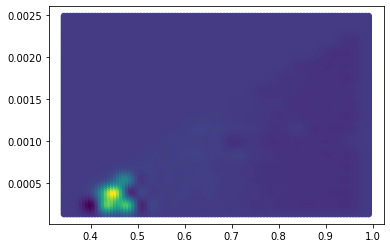

In [62]:
y_pred, MSE = gpmodel.predict(x1x2_test_reform, return_std=True) 

# You should be able to look at x1_test_inv and x2_test_inx and be able to see the same mesh but just with scaled acise
x1_test_inv = scalerx1.inverse_transform(x1x2_test[:,0]) # get to points of scatter, also no need for extra [:,0] as needed in 2D formate for inverse
x2_test_inv = scalerx2.inverse_transform(x1x2_test[:,1])
y_pred_inv = scalery.inverse_transform(y_pred)
plt.scatter(x1_test_inv, x2_test_inv, c = y_pred_inv)

In [63]:
# now here is where you need to decide whether to look at original or scaled data
x1 = x1_training
x2 = x2_training
y = y_training

# Not necessary to be 1D or not, jsut need to have enoguh elements in correct oreitnation to reorder
x1_mesh_prep = x1_test_inv
x2_mesh_prep = x2_test_inv
y_mesh_prep = y_pred_inv

In [64]:
X1 = x1_mesh_prep.reshape(dim_x2_test, dim_x1_test)
X2 = x2_mesh_prep.reshape(dim_x2_test, dim_x1_test)
Y = np.reshape(y_mesh_prep,(dim_x2_test,dim_x1_test))

In [65]:
# %matplotlib qt

Text(0, 0.5, 'PFH wtf')

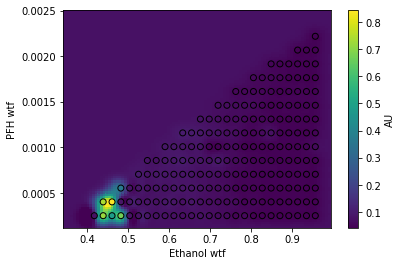

In [66]:
fig, ax = plt.subplots(1)

# where should the vmin and vmax, it should be on training data
vmin = min(y) # anything fed into mpl will expose it to the final
vmax = max(y)
norm =colors.Normalize(vmin=vmin,vmax=vmax) # is this normalization correct?

mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto')
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('AU')
ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')


Text(0.5, 0, 'AU')

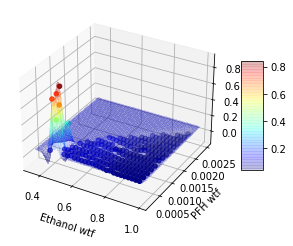

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,x2,y, c=y, norm=norm, cmap='jet')
surf = ax.plot_surface(X=X1, Y=X2, Z=Y, norm=norm, rstride=1, alpha =0.1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
ax.set_zlabel('AU')

In [56]:
%matplotlib inline

In [ ]:
fig, ax = plt.subplots(1)

# where should the vmin and vmax, it should be on training data
vmin = min(y_training_scaled) # anything fed into mpl will expose it to the final
vmax = max(y_training_scaled)
norm =colors.Normalize(vmin=vmin,vmax=vmax) # is this normalization correct?

mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto')
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('AU')
ax.scatter(x1_training_scaled,x2_training_scaled,c=y_training_scaled, norm=norm, edgecolors='k')
ax.set_xlabel('Ethanol')
ax.set_ylabel('PFH')

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_training_scaled,x2_training_scaled,y_training_scaled, c=y_training_scaled, norm=norm, cmap='jet')
surf = ax.plot_surface(X=X1, Y=X2, Z=Y, norm=norm, rstride=1, alpha =0.1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Ethanol')
ax.set_ylabel('PFH')
ax.set_zlabel('AU')